In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.metrics import jaccard_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import networkx as nx
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료")

# 한글 폰트 깨짐 방지 설정 (윈도우/맥/리눅스 환경별)
import platform
from matplotlib import font_manager, rc

system_name = platform.system()
if system_name == 'Windows':
    font_path = "C:/Windows/Fonts/malgun.ttf"
    rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':  # MacOS
    font_path = "/System/Library/Fonts/AppleGothic.ttf"
    rc('font', family='AppleGothic')
else:  # Linux
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("한글 폰트 설정 완료")


라이브러리 로드 완료
한글 폰트 설정 완료


In [2]:
# 데이터 로드
df = pd.read_csv(r'C:\Users\young\Downloads\w38_user_action6.csv')
df.set_index('USER_SEQ', inplace=True)

# lotto_total, lotto_nonad 컬럼 제거

print("=== 데이터 기본 정보 ===")
print(f"데이터 크기: {df.shape}")
print(f"컬럼명: {list(df.columns)}")
print("\n=== 기본 통계 ===")
print(df.describe())


=== 데이터 기본 정보 ===
데이터 크기: (59778, 12)
컬럼명: ['LIKE_DAYS', 'CARD_DAYS', 'QUIZ_DAYS', 'FOLLOW_DAYS', 'COUPANG_DAYS', 'STRETCHING_DAYS', 'BUZZVILL_DAYS', 'WALK_DAYS', 'RAFFLE_DAYS', 'CHG_DAYS', 'LOTT_TOTAL', 'LOTT_AD']

=== 기본 통계 ===
          LIKE_DAYS     CARD_DAYS     QUIZ_DAYS   FOLLOW_DAYS  COUPANG_DAYS  \
count  59778.000000  59778.000000  59778.000000  59778.000000  59778.000000   
mean       0.004517      0.445565      1.042323      0.000970      0.470390   
std        0.099917      1.511616      2.519027      0.044041      1.744912   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000     12.000000     12.000000      6.000000     12.000000   

       STRETCHING_DAYS  BUZZVILL_DAYS     WALK_DAYS   RAFF

In [3]:
df.reset_index().USER_SEQ.count()

59778

In [4]:
# 1단계: 기본 연관성 파악
print("=== 1단계: 기본 연관성 파악 ===")

# 콘텐츠 컬럼 정의
content_columns = ['LIKE_DAYS', 'CARD_DAYS', 'QUIZ_DAYS', 'FOLLOW_DAYS', 'COUPANG_DAYS', 
                  'STRETCHING_DAYS', 'BUZZVILL_DAYS', 'WALK_DAYS', 'RAFFLE_DAYS', 
                  'CHG_DAYS',  'LOTT_AD', 'LOTT_TOTAL']

# 1-1. 각 콘텐츠별 참여자 수 및 비율
print("\n1-1. 각 콘텐츠별 참여자 수 및 비율:")
participation_stats = []
for col in content_columns:
    if col in df.columns:
        participants = (df[col] > 0).sum()
        total_users = len(df)
        participation_rate = (participants / total_users) * 100
        participation_stats.append({
            'content': col,
            'participants': participants,
            'participation_rate': participation_rate
        })
        print(f"  {col}: {participants:,}명 ({participation_rate:.1f}%)")

participation_df = pd.DataFrame(participation_stats)


=== 1단계: 기본 연관성 파악 ===

1-1. 각 콘텐츠별 참여자 수 및 비율:
  LIKE_DAYS: 193명 (0.3%)
  CARD_DAYS: 9,762명 (16.3%)
  QUIZ_DAYS: 14,600명 (24.4%)
  FOLLOW_DAYS: 45명 (0.1%)
  COUPANG_DAYS: 7,657명 (12.8%)
  STRETCHING_DAYS: 3,092명 (5.2%)
  BUZZVILL_DAYS: 924명 (1.5%)
  WALK_DAYS: 28,401명 (47.5%)
  RAFFLE_DAYS: 38,268명 (64.0%)
  CHG_DAYS: 15,849명 (26.5%)
  LOTT_AD: 8,861명 (14.8%)
  LOTT_TOTAL: 31,650명 (52.9%)


In [5]:
# 1-2. 교차분석: 각 콘텐츠 쌍별 참여자 겹침 분석
print("\n1-2. 교차분석: 콘텐츠 쌍별 참여자 겹침 분석")

# 겹침 분석을 위한 함수
def analyze_content_overlap(df, content_columns):
    overlap_results = []
    
    for i, col1 in enumerate(content_columns):
        if col1 not in df.columns:
            continue
        for j, col2 in enumerate(content_columns):
            if col2 not in df.columns or i >= j:
                continue
                
            # 참여자 집합
            users1 = set(df[df[col1] > 0].index)
            users2 = set(df[df[col2] > 0].index)
            
            # 겹침 계산
            intersection = len(users1 & users2)
            union = len(users1 | users2)
            jaccard = intersection / union if union > 0 else 0
            
            # 조건부 확률
            prob_b_given_a = intersection / len(users1) if len(users1) > 0 else 0
            prob_a_given_b = intersection / len(users2) if len(users2) > 0 else 0
            
            overlap_results.append({
                'content1': col1,
                'content2': col2,
                'intersection': intersection,
                'union': union,
                'jaccard_similarity': jaccard,
                'prob_b_given_a': prob_b_given_a,
                'prob_a_given_b': prob_a_given_b
            })
    
    return pd.DataFrame(overlap_results)

overlap_df = analyze_content_overlap(df, content_columns)

# 상위 겹침 결과 출력
print("\n상위 10개 콘텐츠 쌍 (Jaccard 유사도 기준):")
top_overlaps = overlap_df.nlargest(20, 'jaccard_similarity')
for _, row in top_overlaps.iterrows():
    print(f"  {row['content1']} ↔ {row['content2']}: {row['jaccard_similarity']:.3f} (겹침: {row['intersection']:,}명)")

print(f"\n총 {len(overlap_df)}개의 콘텐츠 쌍 분석 완료")



1-2. 교차분석: 콘텐츠 쌍별 참여자 겹침 분석

상위 10개 콘텐츠 쌍 (Jaccard 유사도 기준):
  CARD_DAYS ↔ QUIZ_DAYS: 0.590 (겹침: 9,044명)
  WALK_DAYS ↔ RAFFLE_DAYS: 0.459 (겹침: 20,989명)
  WALK_DAYS ↔ CHG_DAYS: 0.439 (겹침: 13,510명)
  QUIZ_DAYS ↔ WALK_DAYS: 0.424 (겹침: 12,800명)
  WALK_DAYS ↔ LOTT_TOTAL: 0.392 (겹침: 16,903명)
  CARD_DAYS ↔ COUPANG_DAYS: 0.378 (겹침: 4,776명)
  QUIZ_DAYS ↔ COUPANG_DAYS: 0.373 (겹침: 6,049명)
  QUIZ_DAYS ↔ CHG_DAYS: 0.329 (겹침: 7,540명)
  CHG_DAYS ↔ LOTT_TOTAL: 0.305 (겹침: 11,108명)
  RAFFLE_DAYS ↔ LOTT_TOTAL: 0.305 (겹침: 16,337명)
  COUPANG_DAYS ↔ STRETCHING_DAYS: 0.304 (겹침: 2,505명)
  CARD_DAYS ↔ WALK_DAYS: 0.296 (겹침: 8,722명)
  QUIZ_DAYS ↔ LOTT_TOTAL: 0.294 (겹침: 10,518명)
  QUIZ_DAYS ↔ LOTT_AD: 0.289 (겹침: 5,258명)
  QUIZ_DAYS ↔ RAFFLE_DAYS: 0.288 (겹침: 11,819명)
  CARD_DAYS ↔ LOTT_AD: 0.282 (겹침: 4,091명)
  LOTT_AD ↔ LOTT_TOTAL: 0.280 (겹침: 8,858명)
  CARD_DAYS ↔ CHG_DAYS: 0.260 (겹침: 5,289명)
  CARD_DAYS ↔ STRETCHING_DAYS: 0.244 (겹침: 2,522명)
  RAFFLE_DAYS ↔ CHG_DAYS: 0.238 (겹침: 10,409명)

총 66개의 콘텐츠 쌍 분석 완료


In [6]:
df.LOTT_AD.value_counts()

LOTT_AD
0     50917
1      3239
2      1034
10      812
9       698
3       599
8       491
4       478
7       460
5       447
6       440
11      163
Name: count, dtype: int64


1-3. 상관관계 분석


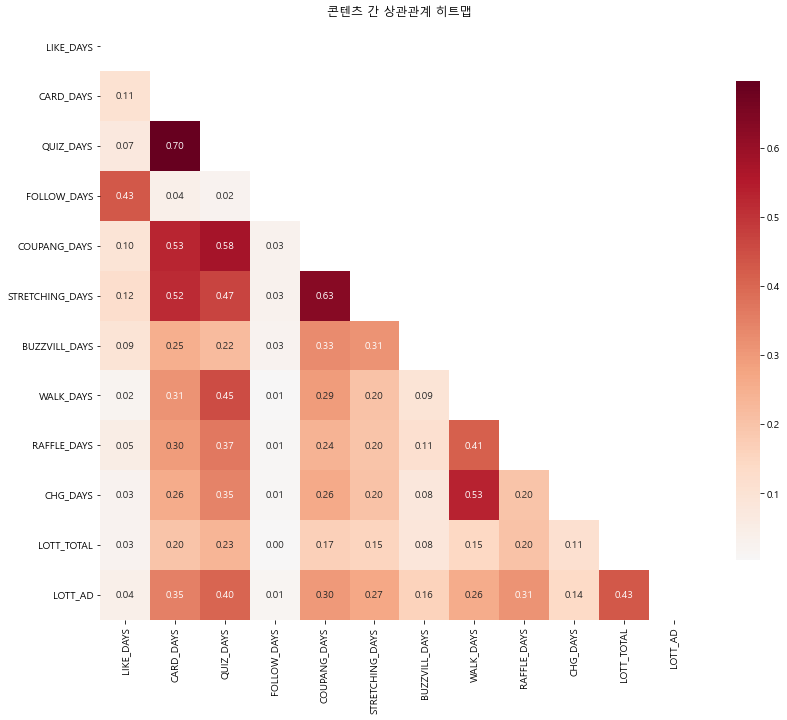


높은 상관관계를 보이는 콘텐츠 쌍 (|r| > 0.3):
  CARD_DAYS ↔ QUIZ_DAYS: 0.696
  COUPANG_DAYS ↔ STRETCHING_DAYS: 0.633
  QUIZ_DAYS ↔ COUPANG_DAYS: 0.577
  WALK_DAYS ↔ CHG_DAYS: 0.532
  CARD_DAYS ↔ COUPANG_DAYS: 0.526
  CARD_DAYS ↔ STRETCHING_DAYS: 0.518
  QUIZ_DAYS ↔ STRETCHING_DAYS: 0.469
  QUIZ_DAYS ↔ WALK_DAYS: 0.453
  LOTT_TOTAL ↔ LOTT_AD: 0.432
  LIKE_DAYS ↔ FOLLOW_DAYS: 0.429
  WALK_DAYS ↔ RAFFLE_DAYS: 0.414
  QUIZ_DAYS ↔ LOTT_AD: 0.403
  QUIZ_DAYS ↔ RAFFLE_DAYS: 0.368
  CARD_DAYS ↔ LOTT_AD: 0.350
  QUIZ_DAYS ↔ CHG_DAYS: 0.345
  COUPANG_DAYS ↔ BUZZVILL_DAYS: 0.329
  STRETCHING_DAYS ↔ BUZZVILL_DAYS: 0.314
  CARD_DAYS ↔ WALK_DAYS: 0.314
  RAFFLE_DAYS ↔ LOTT_AD: 0.313
  COUPANG_DAYS ↔ LOTT_AD: 0.301

총 20개의 높은 상관관계 쌍 발견


In [7]:
# 1-3. 상관관계 분석
print("\n1-3. 상관관계 분석")

# 숫자형 컬럼만 선택
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('콘텐츠 간 상관관계 히트맵')
plt.tight_layout()
plt.show()

# 높은 상관관계 쌍 찾기
print("\n높은 상관관계를 보이는 콘텐츠 쌍 (|r| > 0.3):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            high_corr_pairs.append({
                'content1': correlation_matrix.columns[i],
                'content2': correlation_matrix.columns[j],
                'correlation': corr_val
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', key=abs, ascending=False)
for _, row in high_corr_df.iterrows():
    print(f"  {row['content1']} ↔ {row['content2']}: {row['correlation']:.3f}")

print(f"\n총 {len(high_corr_pairs)}개의 높은 상관관계 쌍 발견")



1-4. 공기출현 분석


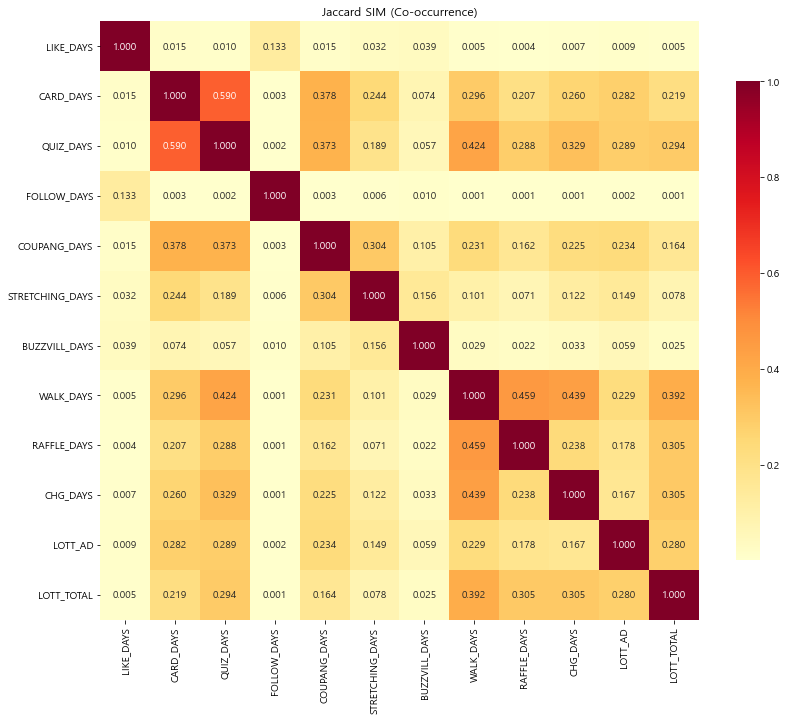

Jaccard sim


In [8]:
# 1-4. 공기출현 분석 (Co-occurrence Analysis)
print("\n1-4. 공기출현 분석")

# Jaccard 유사도 매트릭스 생성
def create_jaccard_matrix(df, content_columns):
    jaccard_matrix = pd.DataFrame(index=content_columns, columns=content_columns)
    
    for col1 in content_columns:
        if col1 not in df.columns:
            continue
        for col2 in content_columns:
            if col2 not in df.columns:
                continue
                
            if col1 == col2:
                jaccard_matrix.loc[col1, col2] = 1.0
            else:
                # 이진 변환 (참여/비참여)
                binary1 = (df[col1] > 0).astype(int)
                binary2 = (df[col2] > 0).astype(int)
                
                # Jaccard 유사도 계산
                jaccard = jaccard_score(binary1, binary2, average='binary')
                jaccard_matrix.loc[col1, col2] = jaccard
    
    return jaccard_matrix.astype(float)

jaccard_matrix = create_jaccard_matrix(df, content_columns)

# Jaccard 유사도 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_matrix, annot=True, cmap='YlOrRd', fmt='.3f', 
            square=True, cbar_kws={"shrink": .8})
plt.title('Jaccard SIM (Co-occurrence)')
plt.tight_layout()
plt.show()

print("Jaccard sim")


In [9]:
df.index.size

59778

In [25]:
# 2단계: 패턴 발견
print("\n=== 2단계: 패턴 발견 ===")

# 2-1. 연관규칙 분석 (Association Rule Mining)
print("\n2-1. 연관규칙 분석")

def find_association_rules(df, content_columns, min_support=0.01, min_confidence=0.1):
    """간단한 연관규칙 분석"""
    rules = []
    
    for col1 in content_columns:
        if col1 not in df.columns:
            continue
        for col2 in content_columns:
            if col2 not in df.columns or col1 == col2:
                continue
                
            # 이진 변환
            binary1 = (df[col1] > 0).astype(int)
            binary2 = (df[col2] > 0).astype(int)
            
            # 지지도, 신뢰도, 향상도 계산
            support_ab = ((binary1 == 1) & (binary2 == 1)).sum() / len(df)
            support_a = (binary1 == 1).sum() / len(df)
            support_b = (binary2 == 1).sum() / len(df)
            
            if support_a > 0:
                confidence = support_ab / support_a
                lift = confidence / support_b if support_b > 0 else 0
                
                if support_ab >= min_support and confidence >= min_confidence:
                    rules.append({
                        'antecedent': col1,
                        'consequent': col2,
                        'support': support_ab,
                        'confidence': confidence,
                        'lift': lift
                    })
    
    return pd.DataFrame(rules).sort_values('lift', ascending=False)

# 연관규칙 찾기
rules_df = find_association_rules(df, content_columns, min_support=0.005, min_confidence=0.1)

print(f"발견된 연관규칙 수: {len(rules_df)}개")
if len(rules_df) > 0:
    print("\n상위 10개 연관규칙 (향상도 기준):")
    for i, (_, rule) in enumerate(rules_df.head(100).iterrows()):
        print(f"  {i+1}. {rule['antecedent']} → {rule['consequent']}")
        print(f"     지지도: {rule['support']:.3f}, 신뢰도: {rule['confidence']:.3f}, 향상도: {rule['lift']:.3f}")
else:
    print("조건을 만족하는 연관규칙이 없습니다. 기준을 낮춰보겠습니다.")
    rules_df = find_association_rules(df, content_columns, min_support=0.05, min_confidence=0.05)
    print(f"낮은 기준으로 발견된 연관규칙 수: {len(rules_df)}개")



=== 2단계: 패턴 발견 ===

2-1. 연관규칙 분석
발견된 연관규칙 수: 64개

상위 10개 연관규칙 (향상도 기준):
  1. COUPANG_DAYS → STRETCHING_DAYS
     지지도: 0.012, 신뢰도: 0.327, 향상도: 21.675
  2. STRETCHING_DAYS → COUPANG_DAYS
     지지도: 0.012, 신뢰도: 0.810, 향상도: 21.675
  3. CARD_DAYS → STRETCHING_DAYS
     지지도: 0.012, 신뢰도: 0.258, 향상도: 17.117
  4. STRETCHING_DAYS → CARD_DAYS
     지지도: 0.012, 신뢰도: 0.816, 향상도: 17.117
  5. COUPANG_DAYS → CARD_DAYS
     지지도: 0.023, 신뢰도: 0.624, 향상도: 13.089
  6. CARD_DAYS → COUPANG_DAYS
     지지도: 0.023, 신뢰도: 0.489, 향상도: 13.089
  7. CARD_DAYS → QUIZ_DAYS
     지지도: 0.044, 신뢰도: 0.926, 향상도: 12.999
  8. QUIZ_DAYS → CARD_DAYS
     지지도: 0.044, 신뢰도: 0.619, 향상도: 12.999
  9. QUIZ_DAYS → STRETCHING_DAYS
     지지도: 0.014, 신뢰도: 0.193, 향상도: 12.788
  10. STRETCHING_DAYS → QUIZ_DAYS
     지지도: 0.014, 신뢰도: 0.911, 향상도: 12.788
  11. QUIZ_DAYS → COUPANG_DAYS
     지지도: 0.030, 신뢰도: 0.414, 향상도: 11.085
  12. COUPANG_DAYS → QUIZ_DAYS
     지지도: 0.030, 신뢰도: 0.790, 향상도: 11.085
  13. STRETCHING_DAYS → LOTT_AD
     지지도: 0.008, 신뢰도: 


2-2. 클러스터 분석
클러스터링을 위한 데이터 크기: (59778, 12)


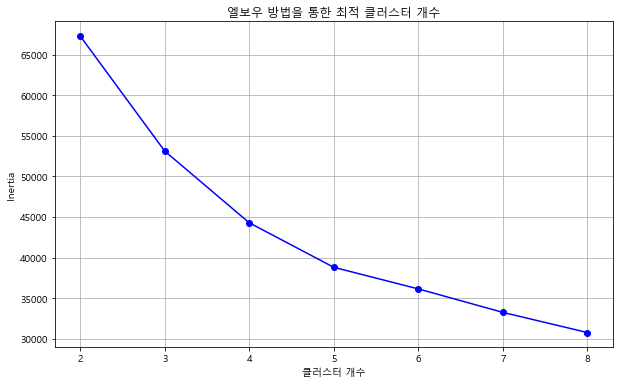


4개 클러스터로 분석:
K-means 클러스터 크기: [18051 16506 14307 10914]
계층적 클러스터링은 데이터가 커서 생략하였습니다.


In [11]:
# 2-2. 클러스터 분석 (Cluster Analysis)
print("\n2-2. 클러스터 분석")

# 사용자별 참여 패턴을 이진 벡터로 변환
binary_data = pd.DataFrame()
for col in content_columns:
    if col in df.columns:
        binary_data[col] = (df[col] > 0).astype(int)

print(f"클러스터링을 위한 데이터 크기: {binary_data.shape}")

# K-means 클러스터링만 수행 (계층적 클러스터링은 대용량 데이터에서 메모리 문제로 제외)
def perform_kmeans_clustering(data, n_clusters_range=(2, 8)):
    """다양한 클러스터 수로 K-means 클러스터링만 수행"""
    results = {}
    
    for n_clusters in range(n_clusters_range[0], n_clusters_range[1] + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(data)
        results[n_clusters] = {
            'kmeans': kmeans_labels,
            'kmeans_inertia': kmeans.inertia_
        }
    
    return results

# 클러스터링 수행
clustering_results = perform_kmeans_clustering(binary_data)

# 최적 클러스터 수 찾기 (엘보우 방법)
inertias = [clustering_results[k]['kmeans_inertia'] for k in clustering_results.keys()]
plt.figure(figsize=(10, 6))
plt.plot(list(clustering_results.keys()), inertias, 'bo-')
plt.xlabel('클러스터 개수')
plt.ylabel('Inertia')
plt.title('엘보우 방법을 통한 최적 클러스터 개수')
plt.grid(True)
plt.show()

# 4개 클러스터로 분석 (일반적으로 적당한 수)
optimal_k = 4
kmeans_labels = clustering_results[optimal_k]['kmeans']

print(f"\n{optimal_k}개 클러스터로 분석:")
print(f"K-means 클러스터 크기: {np.bincount(kmeans_labels)}")
print("계층적 클러스터링은 데이터가 커서 생략하였습니다.")



2-3. 클러스터별 콘텐츠 선호도 분석
K-means 클러스터별 콘텐츠 선호도:

클러스터 0 (크기: 18,051명, 30.2%)
  1. WALK_DAYS: 100.0%
  2. RAFFLE_DAYS: 65.1%
  3. LOTT_TOTAL: 46.7%
  4. CHG_DAYS: 40.4%
  5. QUIZ_DAYS: 15.2%
  6. LOTT_AD: 10.6%
  7. COUPANG_DAYS: 6.3%
  8. CARD_DAYS: 1.4%
  9. STRETCHING_DAYS: 0.9%
  10. BUZZVILL_DAYS: 0.2%
  11. LIKE_DAYS: 0.1%
  12. FOLLOW_DAYS: 0.0%

클러스터 1 (크기: 16,506명, 27.6%)
  1. RAFFLE_DAYS: 89.0%
  2. CHG_DAYS: 6.9%
  3. QUIZ_DAYS: 4.3%
  4. COUPANG_DAYS: 2.3%
  5. CARD_DAYS: 2.1%
  6. STRETCHING_DAYS: 0.2%
  7. BUZZVILL_DAYS: 0.2%
  8. LIKE_DAYS: 0.1%
  9. FOLLOW_DAYS: 0.0%
  10. WALK_DAYS: 0.0%
  11. LOTT_AD: 0.0%
  12. LOTT_TOTAL: 0.0%

클러스터 2 (크기: 14,307명, 23.9%)
  1. LOTT_TOTAL: 100.0%
  2. RAFFLE_DAYS: 15.4%
  3. LOTT_AD: 11.9%
  4. CHG_DAYS: 7.1%
  5. QUIZ_DAYS: 3.8%
  6. CARD_DAYS: 1.3%
  7. COUPANG_DAYS: 1.3%
  8. STRETCHING_DAYS: 0.3%
  9. BUZZVILL_DAYS: 0.1%
  10. LIKE_DAYS: 0.1%
  11. FOLLOW_DAYS: 0.0%
  12. WALK_DAYS: 0.0%

클러스터 3 (크기: 10,914명, 18.3%)
  1. QUIZ_DAYS: 

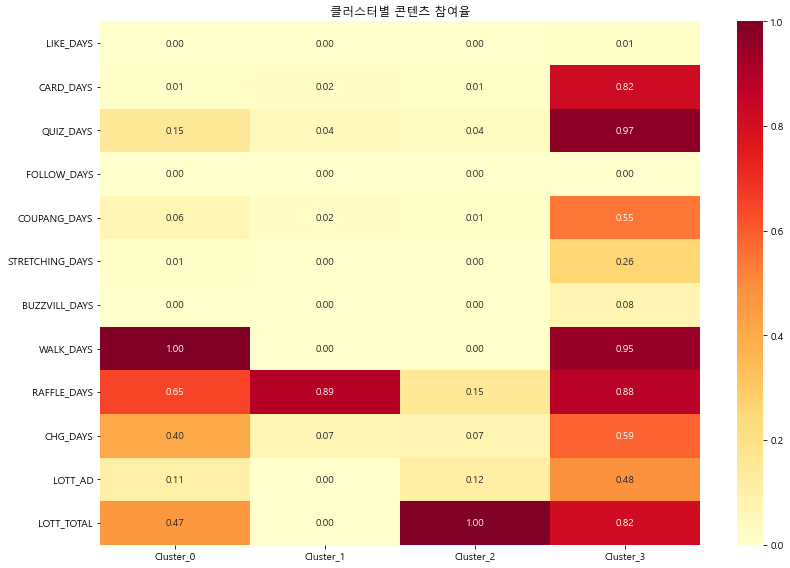

In [12]:
# 2-3. 클러스터별 콘텐츠 선호도 분석
print("\n2-3. 클러스터별 콘텐츠 선호도 분석")

# 클러스터별 콘텐츠 참여율 계산
def analyze_cluster_preferences(binary_data, labels, content_columns):
    """클러스터별 콘텐츠 선호도 분석"""
    cluster_preferences = []
    
    for cluster_id in range(max(labels) + 1):
        cluster_mask = labels == cluster_id
        cluster_data = binary_data[cluster_mask]
        cluster_size = len(cluster_data)
        
        if cluster_size > 0:
            preferences = {}
            for col in content_columns:
                if col in binary_data.columns:
                    participation_rate = cluster_data[col].mean()
                    preferences[col] = participation_rate
            
            cluster_preferences.append({
                'cluster': cluster_id,
                'size': cluster_size,
                'size_ratio': cluster_size / len(binary_data),
                'preferences': preferences
            })
    
    return cluster_preferences

# K-means 클러스터 분석
kmeans_preferences = analyze_cluster_preferences(binary_data, kmeans_labels, content_columns)

print("K-means 클러스터별 콘텐츠 선호도:")
for cluster_info in kmeans_preferences:
    print(f"\n클러스터 {cluster_info['cluster']} (크기: {cluster_info['size']:,}명, {cluster_info['size_ratio']*100:.1f}%)")
    
    # 상위 5개 선호 콘텐츠
    sorted_prefs = sorted(cluster_info['preferences'].items(), key=lambda x: x[1], reverse=True)
    for i, (content, rate) in enumerate(sorted_prefs[:]):
        print(f"  {i+1}. {content}: {rate*100:.1f}%")

# 클러스터별 선호도 히트맵
cluster_pref_matrix = pd.DataFrame()
for cluster_info in kmeans_preferences:
    cluster_pref_matrix[f"Cluster_{cluster_info['cluster']}"] = pd.Series(cluster_info['preferences'])

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_pref_matrix, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('클러스터별 콘텐츠 참여율')
plt.tight_layout()
plt.show()



2-4. 네트워크 분석
네트워크 노드 수: 12
네트워크 엣지 수: 26


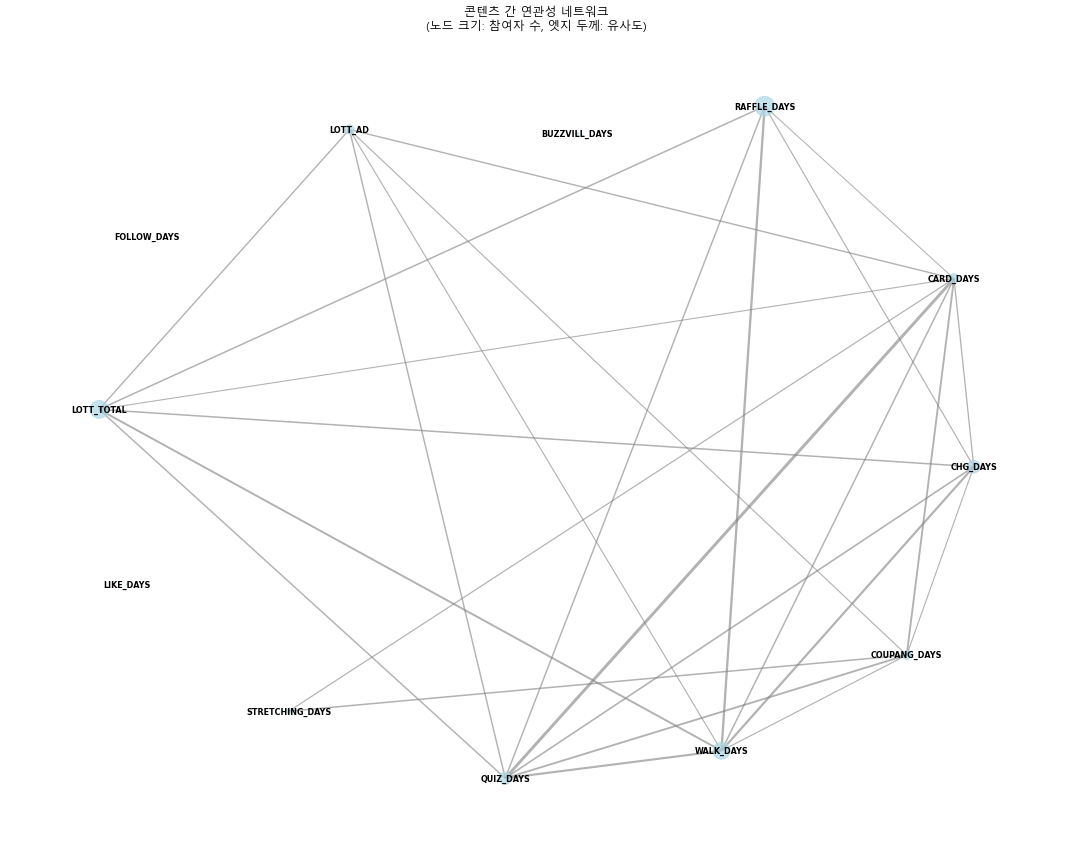


네트워크 중심성 분석:

DEGREE 중심성 (상위 5개):
  1. CARD_DAYS: 0.727
  2. QUIZ_DAYS: 0.636
  3. WALK_DAYS: 0.636
  4. COUPANG_DAYS: 0.545
  5. CHG_DAYS: 0.545

BETWEENNESS 중심성 (상위 5개):
  1. CARD_DAYS: 0.089
  2. COUPANG_DAYS: 0.040
  3. QUIZ_DAYS: 0.016
  4. WALK_DAYS: 0.016
  5. LOTT_TOTAL: 0.008

CLOSENESS 중심성 (상위 5개):
  1. CARD_DAYS: 0.727
  2. QUIZ_DAYS: 0.646
  3. WALK_DAYS: 0.646
  4. COUPANG_DAYS: 0.582
  5. CHG_DAYS: 0.582

EIGENVECTOR 중심성 (상위 5개):
  1. CARD_DAYS: 0.405
  2. QUIZ_DAYS: 0.389
  3. WALK_DAYS: 0.389
  4. CHG_DAYS: 0.347
  5. LOTT_TOTAL: 0.345


In [13]:
# 2-4. 네트워크 분석 (Network Analysis)
print("\n2-4. 네트워크 분석")

# 네트워크 그래프 생성
def create_content_network(jaccard_matrix, threshold=0.1):
    """콘텐츠 간 네트워크 그래프 생성"""
    G = nx.Graph()
    
    # 노드 추가
    for content in jaccard_matrix.index:
        G.add_node(content)
    
    # 엣지 추가 (임계값 이상의 유사도)
    for i, content1 in enumerate(jaccard_matrix.index):
        for j, content2 in enumerate(jaccard_matrix.columns):
            if i < j:  # 중복 방지
                similarity = jaccard_matrix.loc[content1, content2]
                if similarity >= threshold:
                    G.add_edge(content1, content2, weight=similarity)
    
    return G

# 네트워크 생성
network = create_content_network(jaccard_matrix, threshold=0.2)

print(f"네트워크 노드 수: {network.number_of_nodes()}")
print(f"네트워크 엣지 수: {network.number_of_edges()}")

# 네트워크 시각화
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(network, k=3, iterations=50)

# 노드 크기 (참여자 수에 비례)
node_sizes = []
for node in network.nodes():
    if node in participation_df['content'].values:
        size = participation_df[participation_df['content'] == node]['participants'].iloc[0]
        node_sizes.append(size / 100)  # 크기 조정
    else:
        node_sizes.append(100)

# 엣지 두께 (유사도에 비례)
edge_weights = [network[u][v]['weight'] * 5 for u, v in network.edges()]

# 그래프 그리기
nx.draw_networkx_nodes(network, pos, node_size=node_sizes, 
                      node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(network, pos, width=edge_weights, 
                      edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(network, pos, font_size=8, font_weight='bold')

plt.title('콘텐츠 간 연관성 네트워크\n(노드 크기: 참여자 수, 엣지 두께: 유사도)')
plt.axis('off')
plt.tight_layout()
plt.show()

# 네트워크 중심성 분석
print("\n네트워크 중심성 분석:")
centrality_measures = {
    'degree': nx.degree_centrality(network),
    'betweenness': nx.betweenness_centrality(network),
    'closeness': nx.closeness_centrality(network),
    'eigenvector': nx.eigenvector_centrality(network, max_iter=1000)
}

for measure_name, measures in centrality_measures.items():
    print(f"\n{measure_name.upper()} 중심성 (상위 5개):")
    sorted_centrality = sorted(measures.items(), key=lambda x: x[1], reverse=True)
    for i, (content, centrality) in enumerate(sorted_centrality[:5]):
        print(f"  {i+1}. {content}: {centrality:.3f}")


In [14]:
# 계층적 군집(계층 모델)은 제외하고 KMeans 클러스터 정보만 원본 데이터프레임에 추가
print("=== KMeans 클러스터 정보를 원본 데이터프레임에 추가 (계층 모델 제외) ===")

# 원본 데이터프레임에 KMeans 클러스터 열만 추가
df_with_clusters = df.reset_index().copy()
df_with_clusters['KMEANS_CLUSTER'] = kmeans_labels
# 계층적 군집(hierarchical_labels)은 완전히 제외함

print(f"데이터프레임 크기: {df_with_clusters.shape}")
print(f"KMeans 클러스터 열 추가 완료 (계층 모델 제외)")

# KMeans 클러스터별 기본 통계 확인 (계층 모델 통계 없음)
print("\n=== KMeans 클러스터별 기본 통계 (계층 모델 제외) ===")
cluster_stats = df_with_clusters.groupby('KMEANS_CLUSTER').agg({
    'USER_SEQ': 'count',
    'QUIZ_DAYS': ['mean', 'std', 'min', 'max'],
    'WALK_DAYS': ['mean', 'std', 'min', 'max'],
    'CARD_DAYS': ['mean', 'std', 'min', 'max']
}).round(2)

print(cluster_stats)


=== KMeans 클러스터 정보를 원본 데이터프레임에 추가 (계층 모델 제외) ===
데이터프레임 크기: (59778, 14)
KMeans 클러스터 열 추가 완료 (계층 모델 제외)

=== KMeans 클러스터별 기본 통계 (계층 모델 제외) ===
               USER_SEQ QUIZ_DAYS               WALK_DAYS                \
                  count      mean   std min max      mean   std min max   
KMEANS_CLUSTER                                                            
0                 18051      0.42  1.45   0  12      7.99  3.51   1  12   
1                 16506      0.05  0.27   0  10      0.00  0.00   0   0   
2                 14307      0.06  0.44   0  11      0.00  0.00   0   0   
3                 10914      4.87  3.59   0  12      8.35  3.50   0  12   

               CARD_DAYS                
                    mean   std min max  
KMEANS_CLUSTER                          
0                   0.01  0.14   0  10  
1                   0.02  0.16   0   6  
2                   0.02  0.14   0   5  
3                   2.36  2.81   0  12  


In [15]:
# 클러스터별 상세 분석
print("\n=== 클러스터별 상세 분석 ===")

# 각 클러스터의 실제 참여일 수 분포 확인
for cluster_id in range(4):
    cluster_data = df_with_clusters[df_with_clusters['KMEANS_CLUSTER'] == cluster_id]
    print(f"\n--- 클러스터 {cluster_id} ({len(cluster_data):,}명) ---")
    
    # 주요 콘텐츠별 참여일 수 통계
    key_contents = ['QUIZ_DAYS', 'WALK_DAYS', 'CARD_DAYS', 'CHG_DAYS', 'RAFFLE_DAYS']
    for content in key_contents:
        if content in cluster_data.columns:
            stats = cluster_data[content].describe()
            print(f"{content}: 평균={stats['mean']:.2f}, 중앙값={stats['50%']:.2f}, 최대={stats['max']:.2f}")
    
    # 0값 비율 확인
    print("0값 비율:")
    for content in key_contents:
        if content in cluster_data.columns:
            zero_ratio = (cluster_data[content] == 0).sum() / len(cluster_data) * 100
            print(f"  {content}: {zero_ratio:.1f}%")



=== 클러스터별 상세 분석 ===

--- 클러스터 0 (18,051명) ---
QUIZ_DAYS: 평균=0.42, 중앙값=0.00, 최대=12.00
WALK_DAYS: 평균=7.99, 중앙값=10.00, 최대=12.00
CARD_DAYS: 평균=0.01, 중앙값=0.00, 최대=10.00
CHG_DAYS: 평균=3.74, 중앙값=0.00, 최대=11.00
RAFFLE_DAYS: 평균=1.58, 중앙값=1.00, 최대=12.00
0값 비율:
  QUIZ_DAYS: 84.8%
  WALK_DAYS: 0.0%
  CARD_DAYS: 98.6%
  CHG_DAYS: 59.6%
  RAFFLE_DAYS: 34.9%

--- 클러스터 1 (16,506명) ---
QUIZ_DAYS: 평균=0.05, 중앙값=0.00, 최대=10.00
WALK_DAYS: 평균=0.00, 중앙값=0.00, 최대=0.00
CARD_DAYS: 평균=0.02, 중앙값=0.00, 최대=6.00
CHG_DAYS: 평균=0.59, 중앙값=0.00, 최대=11.00
RAFFLE_DAYS: 평균=0.90, 중앙값=1.00, 최대=11.00
0값 비율:
  QUIZ_DAYS: 95.7%
  WALK_DAYS: 100.0%
  CARD_DAYS: 97.9%
  CHG_DAYS: 93.1%
  RAFFLE_DAYS: 11.0%

--- 클러스터 2 (14,307명) ---
QUIZ_DAYS: 평균=0.06, 중앙값=0.00, 최대=11.00
WALK_DAYS: 평균=0.00, 중앙값=0.00, 최대=0.00
CARD_DAYS: 평균=0.02, 중앙값=0.00, 최대=5.00
CHG_DAYS: 평균=0.62, 중앙값=0.00, 최대=11.00
RAFFLE_DAYS: 평균=0.22, 중앙값=0.00, 최대=12.00
0값 비율:
  QUIZ_DAYS: 96.2%
  WALK_DAYS: 100.0%
  CARD_DAYS: 98.7%
  CHG_DAYS: 92.9%
  RAFFLE_DAYS: 84.6%

--- 클

In [16]:
# 클러스터 1의 실제 데이터 샘플 확인
print("\n=== 클러스터 1 실제 데이터 샘플 ===")

cluster_1_data = df_with_clusters[df_with_clusters['KMEANS_CLUSTER'] == 1]
print(f"클러스터 1 크기: {len(cluster_1_data):,}명")

# 상위 10개 사용자 데이터 확인
print("\n클러스터 1 상위 10개 사용자 데이터:")
sample_users = cluster_1_data.head(10)
key_columns = ['QUIZ_DAYS', 'WALK_DAYS', 'CARD_DAYS', 'CHG_DAYS', 'RAFFLE_DAYS', 'COUPANG_DAYS', 'STRETCHING_DAYS']
print(sample_users[key_columns])

# 클러스터 1의 참여 패턴 분석
print("\n클러스터 1 참여 패턴:")
print("참여일 수 분포:")
for content in key_columns:
    if content in cluster_1_data.columns:
        non_zero_data = cluster_1_data[cluster_1_data[content] > 0][content]
        if len(non_zero_data) > 0:
            print(f"{content}: {len(non_zero_data):,}명 참여, 평균 {non_zero_data.mean():.2f}일")
        else:
            print(f"{content}: 0명 참여")

# 클러스터 1의 총 참여일 수 합계
print("\n클러스터 1 사용자별 총 참여일 수:")
cluster_1_data['TOTAL_DAYS'] = cluster_1_data[key_columns].sum(axis=1)
print(f"총 참여일 수 통계:")
print(cluster_1_data['TOTAL_DAYS'].describe())



=== 클러스터 1 실제 데이터 샘플 ===
클러스터 1 크기: 16,506명

클러스터 1 상위 10개 사용자 데이터:
     QUIZ_DAYS  WALK_DAYS  CARD_DAYS  CHG_DAYS  RAFFLE_DAYS  COUPANG_DAYS  \
0            0          0          1         0            1             1   
7            1          0          1         0            0             0   
13           1          0          1         0            0             0   
22           0          0          0         0            0             0   
36           0          0          1         0            0             0   
91           0          0          0        11            0             0   
99           0          0          0         9            0             0   
106          0          0          0         1            0             0   
160          0          0          0        10            0             0   
167          1          0          1         0            0             0   

     STRETCHING_DAYS  
0                  1  
7                  0  
13            

In [17]:
# 2단계 요약 및 인사이트
print("\n=== 2단계 요약 및 인사이트 ===")

print("\n🎯 주요 발견사항:")
print(f"1. 총 {len(content_columns)}개 콘텐츠 분석")
print(f"2. {len(overlap_df)}개 콘텐츠 쌍의 겹침 분석")
print(f"3. {len(rules_df)}개의 연관규칙 발견")
print(f"4. {optimal_k}개 사용자 클러스터 식별")
print(f"5. {network.number_of_edges()}개의 콘텐츠 연결 관계")

print("\n📊 콘텐츠 연관성 패턴:")
if len(rules_df) > 0:
    print("강한 연관규칙 (향상도 > 1.5):")
    strong_rules = rules_df[rules_df['lift'] > 1.5]
    for _, rule in strong_rules.head(5).iterrows():
        print(f"  - {rule['antecedent']} → {rule['consequent']} (향상도: {rule['lift']:.2f})")

print("\n👥 사용자 세그먼트 특성:")
for i, cluster_info in enumerate(kmeans_preferences):
    print(f"세그먼트 {i+1} ({cluster_info['size_ratio']*100:.1f}%):")
    top_contents = sorted(cluster_info['preferences'].items(), key=lambda x: x[1], reverse=True)[:3]
    for content, rate in top_contents:
        print(f"  - {content}: {rate*100:.1f}%")

print("\n🔗 핵심 콘텐츠 (네트워크 중심성):")
degree_centrality = centrality_measures['degree']
top_central = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for i, (content, centrality) in enumerate(top_central):
    print(f"  {i+1}. {content}: {centrality:.3f}")

print("\n💡 비즈니스 인사이트:")
print("1. 연관성 높은 콘텐츠들을 묶어서 마케팅")
print("2. 사용자 세그먼트별 맞춤 콘텐츠 추천")
print("3. 핵심 콘텐츠 중심으로 사용자 유입 전략")
print("4. 콘텐츠 간 시너지 효과 활용")



=== 2단계 요약 및 인사이트 ===

🎯 주요 발견사항:
1. 총 12개 콘텐츠 분석
2. 66개 콘텐츠 쌍의 겹침 분석
3. 81개의 연관규칙 발견
4. 4개 사용자 클러스터 식별
5. 26개의 콘텐츠 연결 관계

📊 콘텐츠 연관성 패턴:
강한 연관규칙 (향상도 > 1.5):
  - STRETCHING_DAYS → BUZZVILL_DAYS (향상도: 11.32)
  - BUZZVILL_DAYS → STRETCHING_DAYS (향상도: 11.32)
  - BUZZVILL_DAYS → COUPANG_DAYS (향상도: 6.87)
  - COUPANG_DAYS → BUZZVILL_DAYS (향상도: 6.87)
  - STRETCHING_DAYS → COUPANG_DAYS (향상도: 6.32)

👥 사용자 세그먼트 특성:
세그먼트 1 (30.2%):
  - WALK_DAYS: 100.0%
  - RAFFLE_DAYS: 65.1%
  - LOTT_TOTAL: 46.7%
세그먼트 2 (27.6%):
  - RAFFLE_DAYS: 89.0%
  - CHG_DAYS: 6.9%
  - QUIZ_DAYS: 4.3%
세그먼트 3 (23.9%):
  - LOTT_TOTAL: 100.0%
  - RAFFLE_DAYS: 15.4%
  - LOTT_AD: 11.9%
세그먼트 4 (18.3%):
  - QUIZ_DAYS: 97.2%
  - WALK_DAYS: 94.8%
  - RAFFLE_DAYS: 88.2%

🔗 핵심 콘텐츠 (네트워크 중심성):
  1. CARD_DAYS: 0.727
  2. QUIZ_DAYS: 0.636
  3. WALK_DAYS: 0.636
  4. COUPANG_DAYS: 0.545
  5. CHG_DAYS: 0.545

💡 비즈니스 인사이트:
1. 연관성 높은 콘텐츠들을 묶어서 마케팅
2. 사용자 세그먼트별 맞춤 콘텐츠 추천
3. 핵심 콘텐츠 중심으로 사용자 유입 전략
4. 콘텐츠 간 시너지 효과 활용


In [18]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels import api as sm

In [19]:
df = pd.read_csv(r'C:\Users\young\Downloads\w38_user_action2.csv')

In [20]:
df.set_index('USER_SEQ', inplace=True)
df.head()

,LIKE_DAYS,CARD_DAYS,QUIZ_DAYS,FOLLOW_DAYS,COUPANG_DAYS,STRETCHING_DAYS,BUZZVILL_DAYS,WALK_DAYS,RAFFLE_DAYS,CHG_DAYS,LOTT_TOTAL,LOTT_AD,LOTT_NONAD
USER_SEQ,,,,,,,,,,,,,
1.0,0,1,0,0,1,1,0,1,6,0,32,0,32
2.0,0,3,3,0,2,3,1,2,8,8,19,0,19
4.0,0,0,0,0,0,2,1,6,2,3,11,0,11
5.0,0,10,6,0,4,0,0,103,47,8,94,0,94
6.0,0,0,0,0,2,0,1,53,16,12,32,1,32


In [ ]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt=".2f")

plt.title('Correlation Heatmap')
plt.show()

In [22]:
df.corr()['QUIZ_DAYS']

LIKE_DAYS          0.082348
CARD_DAYS          0.716863
QUIZ_DAYS          1.000000
FOLLOW_DAYS        0.029524
COUPANG_DAYS       0.604283
STRETCHING_DAYS    0.485944
BUZZVILL_DAYS      0.229617
WALK_DAYS          0.509751
RAFFLE_DAYS        0.353798
CHG_DAYS           0.436454
LOTT_TOTAL         0.426865
LOTT_AD            0.485035
LOTT_NONAD         0.426866
Name: QUIZ_DAYS, dtype: float64

In [23]:
# 1. 각 콘텐츠 간 연관성 확인
print("=== 데이터 기본 정보 ===")
print(f"데이터 크기: {df.shape}")
print(f"컬럼명: {list(df.columns)}")
print("\n=== 기본 통계 ===")
print(df.describe())


=== 데이터 기본 정보 ===
데이터 크기: (204857, 13)
컬럼명: ['LIKE_DAYS', 'CARD_DAYS', 'QUIZ_DAYS', 'FOLLOW_DAYS', 'COUPANG_DAYS', 'STRETCHING_DAYS', 'BUZZVILL_DAYS', 'WALK_DAYS', 'RAFFLE_DAYS', 'CHG_DAYS', 'LOTT_TOTAL', 'LOTT_AD', 'LOTT_NONAD']

=== 기본 통계 ===
           LIKE_DAYS      CARD_DAYS      QUIZ_DAYS    FOLLOW_DAYS  \
count  204857.000000  204857.000000  204857.000000  204857.000000   
mean        0.001318       0.130018       0.304154       0.000283   
std         0.054013       0.841300       1.440880       0.023794   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         8.000000      12.000000      12.000000       6.000000   

        COUPANG_DAYS  STRETCHING_DAYS  BUZZVILL_DAYS      WALK_DAYS  \
count  204857.000000    204857.000000  204857.000000  204857.0